In [1]:
import numpy as np
from numpy import random as rnd
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import shuffle
import sys
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

In [2]:
def mapminmax(array):
    array = np.array(array)
    a = -1
    b = 1
    A = np.min(array)
    B = np.max(array)
    new_array = np.zeros(array.shape)
    if len(array.shape) == 2:
        for i in range(array.shape[0]):
            for j in range(array[i].shape[0]):
                x = array[i][j]
                new_array[i][j] = a+((x-A)*(b-a)/(B-A))
        return new_array
    else:
        for i in range(array.shape[0]):
            new_array[i] = a+((array[i]-A)*(b-a)/(B-A))
        return new_array.astype(np.int)
    
mapminmax([[5.1,3.5,1.4,0.2],[4.9,3.0,1.4,0.2]])

array([[ 1.        ,  0.34693878, -0.51020408, -1.        ],
       [ 0.91836735,  0.14285714, -0.51020408, -1.        ]])

In [3]:
def euclid_dist(x,y):
    temp = 0
    for i,j in zip(x,y):
        temp += (i-j)**2
        final = np.sqrt(temp)
    return final

In [4]:
def sigmoid(x):
    return 1/(1+np.exp(-x))

In [5]:
input_nodes = 4  #FNN
hidden_nodes = 15
output_nodes = 3
def fnn(w1,w2,b1,b2,x1,x2,x3,x4):
    inputs = np.array([x1,x2,x3,x4])
    hidden_input = inputs.dot(w1)
    
    j = 0
    hidden_output = np.zeros((1,hidden_input.shape[0]))
    for i in hidden_input[None,:]:
        hidden_output[j] = sigmoid(i+b1[j])
        j += 1
    
    hidden_output = np.array(hidden_output)
    output_i = hidden_output.dot(w2)

    k = 0
    output_o = np.zeros(output_i.shape[1])
    for i in output_i[0]:
        output_o[k] = sigmoid(i+b2[k])
        k += 1
    return output_o

In [6]:
# iris dataset taking dataset and putting class labels 1,0
df = pd.read_csv('iris.data', header=None)
df.head()

X = df.drop(4,axis=1).values
Y = df[4].values

le = LabelEncoder()
le.fit(['Iris-setosa','Iris-versicolor','Iris-virginica'])
Y = le.transform(Y)
Y = mapminmax(Y)
X = mapminmax(X)

# X_train = X[:125]
# Y_train = Y[:125]
# X_test = X[125:]
# Y_test = Y[125:]

In [7]:
#500 iterations for 30 particle
max_iters = 500
c1 = 2
c2 = 2
num_particles = 30
g0 = 1
hidden_nodes = 15  
dim = 8*hidden_nodes+3
w=2;                 
wMax=0.9            
wMin=0.5              
current_fitness = np.zeros((num_particles,1))
gbest = np.zeros((1,dim))
gbest_score = float('inf')
weights1 = np.zeros((input_nodes, hidden_nodes))
weights2 = np.zeros((hidden_nodes, output_nodes))
biases1 = np.zeros((1, hidden_nodes))
biases2 = np.zeros((1, output_nodes))
convergence = np.zeros(max_iters)
alpha = 20
epsilon = 1

class Particle:
    pass

#all particle initialized
particles = []
for i in range(num_particles):
    p = Particle()
    p.params = np.array([rnd.rand() for i in range(dim)])
    p.fitness = rnd.rand()
    p.velocity = 0.3*rnd.randn(dim)
    p.res_force = rnd.rand()
    p.acceleration = rnd.randn(dim)
    p.force = np.zeros(dim)
    p.id = i
    particles.append(p)

#training 
for i in range(max_iters):
    # gravitational constant
    g = g0*np.exp((-alpha*i)/max_iters)
    
    # calculate mse
    cf = 0
    for p in particles:
        weights1 = p.params[:60].reshape((4,15))
        weights2 = p.params[60:105].reshape((15,3))
        biases1 = p.params[105:120]
        biases2 = p.params[120:123]
        
        fitness = 0
        y_train = 0
        for t in X:  #ith particle output compare with target , find fitness
            out = fnn(weights1, weights2, biases1, biases2, t[0], t[1], t[2], t[3])
            if Y[y_train] == -1:
                fitness = fitness + (1-out[0])**2 + (0-out[1])**2 + (0-out[2])**2
            elif Y[y_train] == 0:
                fitness = fitness + (0-out[0])**2 + (1-out[1])**2 + (0-out[2])**2
            elif Y[y_train] == 1:
                fitness = fitness + (0-out[0])**2 + (0-out[1])**2 + (1-out[2])**2
            y_train += 1
        
        fitness = fitness/X.shape[0]
        current_fitness[cf] = fitness
        cf += 1
        
        if gbest_score > fitness:
            gbest_score = fitness
            gbest = p.params
    
    best_fit = min(current_fitness)
    worst_fit = max(current_fitness)
    
    for p in particles:
        p.mass = (current_fitness[particles.index(p)]-0.99*worst_fit)/(best_fit-worst_fit)
    
    for p in particles:
        p.mass = p.mass*5/sum([p.mass for p in particles])
    
    
    # gravitational force
    for p in particles:
        for x in particles[particles.index(p)+1:]:
            p.force = (g*(x.mass*p.mass)*(p.params - x.params))/(euclid_dist(p.params,x.params))
    
    # resultant force
    for p in particles:
        p.res_force = p.res_force+rnd.rand()*p.force
    
    # acceleration
    for p in particles:
        p.acc = p.res_force/p.mass
    
    w = wMin-(i*(wMax-wMin)/max_iters)
    
    # velocity
    for p in particles:
        p.velocity = w*p.velocity+rnd.rand()*p.acceleration+rnd.rand()*(gbest - p.params)
    
    # position
    for p in particles:
        p.params = p.params + p.velocity
    
    convergence[i] = gbest_score
    sys.stdout.write('\rPSOGSA is training FNN (Iteration = ' + str(i+1) + ', MSE = ' + str(gbest_score) + ')')
    sys.stdout.flush()

PSOGSA is training FNN (Iteration = 500, MSE = 0.052599046999))

In [8]:
w1 = gbest[:60].reshape((4,15))
w2 = gbest[60:105].reshape((15,3))
b1 = gbest[105:120]
b2 = gbest[120:123]

In [9]:
y = 0
true_samples = 0
for i in X:
    out = fnn(w1,w2,b1,b2,i[0],i[1],i[2],i[3])
    if Y[y] == -1:
        if np.round(out[0]) == 1 and np.round(out[1]) == 0 and np.round(out[2]) == 0:
            true_samples += 1
    if Y[y] == 0:
        if np.round(out[0]) == 0 and np.round(out[1]) == 1 and np.round(out[2]) == 0:
            true_samples += 1
    if Y[y] == 1:
        if np.round(out[0]) == 0 and np.round(out[1]) == 0 and np.round(out[2]) == 1:
            true_samples += 1
    y+=1

classification_rate = (true_samples/X.shape[0])*100
print('Accuracy = ',classification_rate)

Accuracy =  95.33333333333334


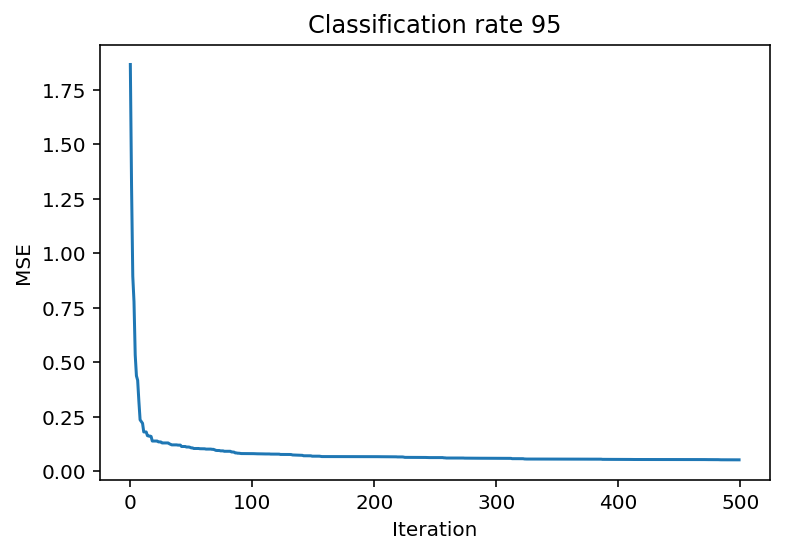

In [10]:
plt.plot(convergence)
plt.xlabel('Iteration')
plt.ylabel('MSE')
plt.title('Classification rate %d' % classification_rate)
plt.show()